
# Survival Analysis Training Tool

This notebook provides an interactive guide through essential Survival Analysis techniques, including **Kaplan-Meier survival curves** and the **Cox proportional hazards model**. We will use synthetic data representing survival times, events, and covariates (e.g., age, sex, and performance status) for a cohort.

### Key Concepts
- **Survival Time**: The time duration until an event of interest (e.g., death, failure) occurs.
- **Censoring**: Cases where the event has not occurred by the end of the study or loss to follow-up.
- **Kaplan-Meier Estimation**: A non-parametric method to estimate the survival function.
- **Cox Proportional Hazards Model**: A regression model that relates the survival time to one or more covariates.


In [32]:
import os
os.chdir("/Users/aaronbeck/Dropbox/Python")


In [18]:
# import pandas
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Define sample size
n = 200

# Generate adjusted synthetic data for the lung dataset
# Men (sex = 1) will have shorter survival times on average, while women (sex = 2) will have longer times.
# Older individuals will have a higher probability of experiencing the event sooner.

synthetic_lung_data_adjusted = pd.DataFrame({
    'time': np.random.exponential(scale=365, size=n) * (1.2 - 0.005 * np.random.normal(60, 10, size=n)),  # Time decreases with age
    'status': np.random.binomial(1, 0.7, size=n),                     # 70% events, 30% censored
    'age': np.random.normal(60, 10, size=n).astype(int),               # Age around 60 years
    'sex': np.random.choice([1, 2], size=n, p=[0.5, 0.5]),            # 1 = male, 2 = female with equal probability
    'ph.ecog': np.random.choice([0, 1, 2, 3], size=n)                 # Performance status with no effect on survival
})

# Adjust time so that men generally have shorter survival times than women
synthetic_lung_data_adjusted['time'] *= np.where(synthetic_lung_data_adjusted['sex'] == 1, 0.8, 1.2)

# Display the first few rows of the adjusted synthetic dataset
synthetic_lung_data_adjusted.head()




,time,status,age,sex,ph.ecog
0,127.982717,1,75,1,1
1,1171.279319,0,65,2,0
2,340.406600,1,49,1,0
3,249.442866,1,58,1,1
4,39.956782,1,51,1,2



## Step 1: Data Preparation and Exploration

We will start by loading the synthetic dataset and performing exploratory data analysis to understand the distribution of survival times and relevant covariates like age, sex, and performance status.


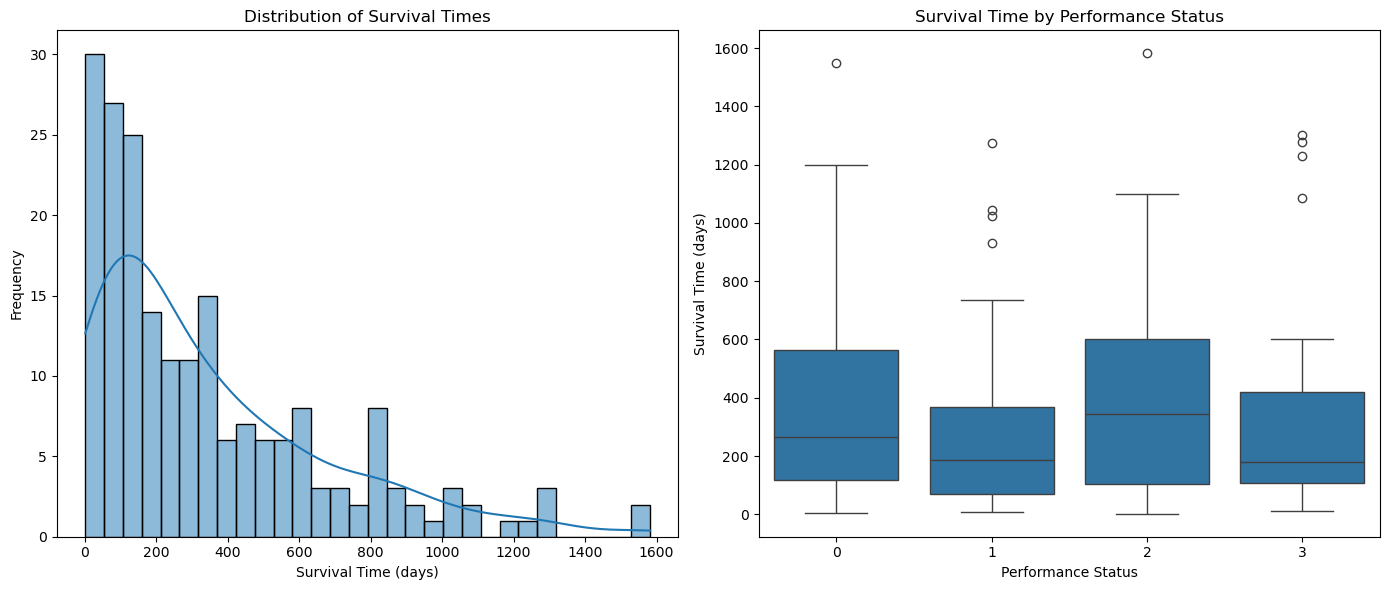

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure for subplots
plt.figure(figsize=(14, 6))

# Plot distribution of survival times
plt.subplot(1, 2, 1)
sns.histplot(synthetic_lung_data['time'], bins=30, kde=True)
plt.title('Distribution of Survival Times')
plt.xlabel('Survival Time (days)')
plt.ylabel('Frequency')

# Boxplot of survival time by performance status
plt.subplot(1, 2, 2)
sns.boxplot(x='ph.ecog', y='time', data=synthetic_lung_data)
plt.title('Survival Time by Performance Status')
plt.xlabel('Performance Status')
plt.ylabel('Survival Time (days)')

plt.tight_layout()
plt.show()


In [12]:
!pip install lifelines


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 4.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 2.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4032 sha256=95a7175161d5762b3dd52f363993472ac7b878cdab8505b705c4b4337e6a6393
  Stored in directory: /Users/aaronbeck/Library/Caches/pip/wheels/e4/30/15/a77aac970f4acc37b9bb9c7f56e73c7c85087f15ff0fb4720f
Successfully built autograd-gamma


In [30]:
import os
print(os.getcwd())


/Users/aaronbeck



## Step 2: Kaplan-Meier Analysis

The Kaplan-Meier estimator is a non-parametric statistic used to estimate the survival function. We will stratify the data by key variables (e.g., `sex` and `performance status`) and plot the survival curves.

The Kaplan-Meier survival curve is a step function that shows the probability of surviving beyond each observed event time.


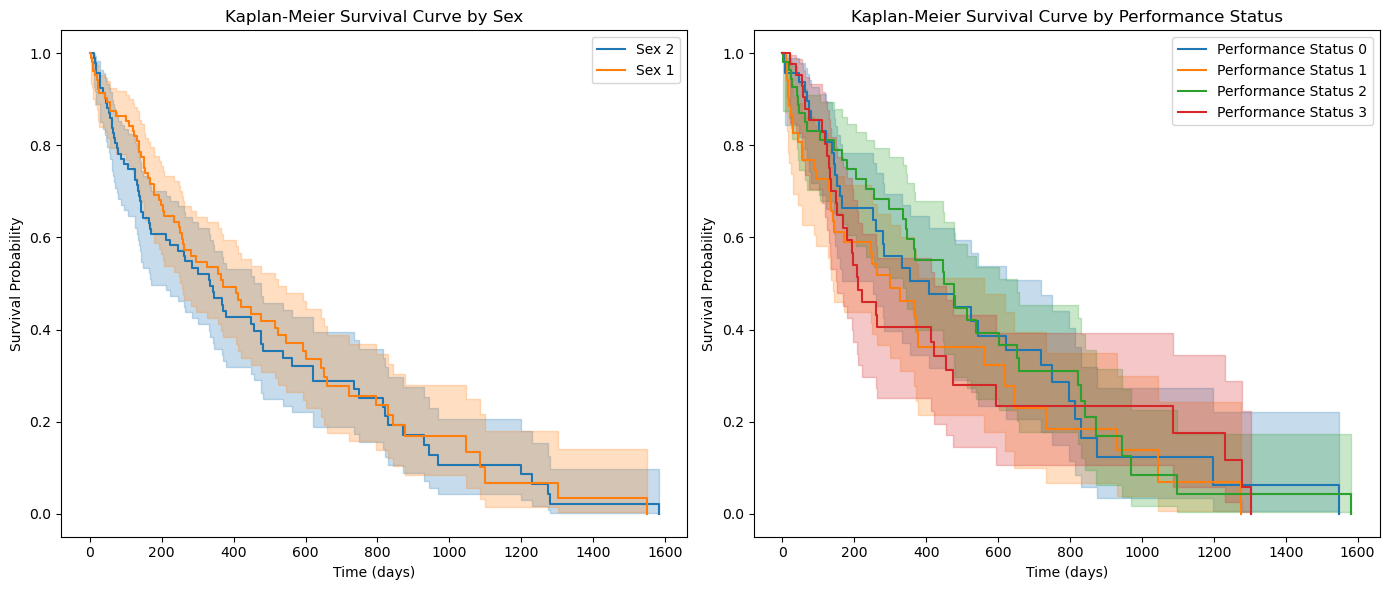

In [22]:
from lifelines import KaplanMeierFitter

# Initialize the KaplanMeierFitter
kmf = KaplanMeierFitter()

# Set up the figure for subplots
plt.figure(figsize=(14, 6))

# Kaplan-Meier curve by sex
plt.subplot(1, 2, 1)
for sex in synthetic_lung_data['sex'].unique():
    kmf.fit(durations=synthetic_lung_data['time'][synthetic_lung_data['sex'] == sex],
            event_observed=synthetic_lung_data['status'][synthetic_lung_data['sex'] == sex],
            label=f'Sex {sex}')
    kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve by Sex')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')

# Kaplan-Meier curve by performance status
plt.subplot(1, 2, 2)
for status in sorted(synthetic_lung_data['ph.ecog'].unique()):
    kmf.fit(durations=synthetic_lung_data['time'][synthetic_lung_data['ph.ecog'] == status],
            event_observed=synthetic_lung_data['status'][synthetic_lung_data['ph.ecog'] == status],
            label=f'Performance Status {status}')
    kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve by Performance Status')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')

plt.tight_layout()
plt.show()


In [24]:
from lifelines import CoxPHFitter

# Initialize Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model to the data
cph.fit(synthetic_lung_data, duration_col='time', event_col='status')

# Display the summary of the model (coefficients and hazard ratios)
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 200 total observations, 60 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 200
number of events observed = 140
   partial log-likelihood = -597.49
         time fit was run = 2024-11-10 13:18:25 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.01           -0.01            0.03                0.99                1.03
sex        0.12      1.13      0.17           -0.22            0.45                0.81                1.57
ph.ecog    0.01      1.01      0.08           -0.15            0.16                0.86                1.18

           cmp to    z    p  -log2(p)
covariate                            
age          0.00 1.22 0.22      2.17
sex          0.00 0.70 0.49      1.04
ph.ecog      0.00 0.11 0.91      0.13
---
Concordance = 0.52
Partial AIC = 1200.97
log-likelihood ratio test = 1.91 on 3 df
-log2(p) of ll-ratio test = 0.76

In [38]:
from lifelines.datasets import load_waltons
data = load_waltons()
print(data.head())


      T  E    group
0   6.0  1  miR-137
1  13.0  1  miR-137
2  13.0  1  miR-137
3  13.0  1  miR-137
4  19.0  1  miR-137


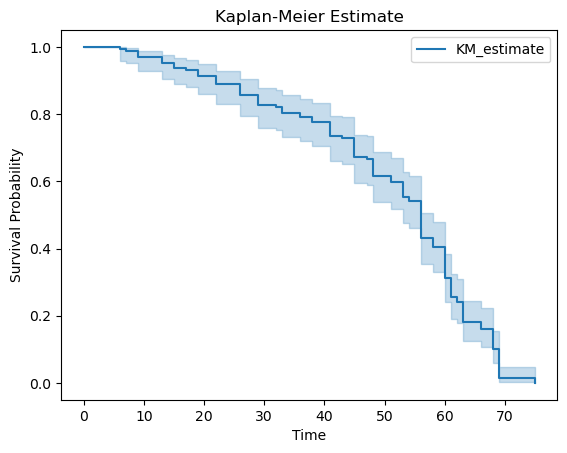

In [40]:
kmf = KaplanMeierFitter()

# Fitting the data
kmf.fit(durations=data['T'], event_observed=data['E'])

# Plotting the survival function
kmf.plot_survival_function()
plt.title('Kaplan-Meier Estimate')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()


## Step 3: Cox Proportional Hazards Model

The Cox proportional hazards model examines the effect of several covariates on survival time. This model assumes that the hazard ratio for any two individuals is proportional over time, which is known as the **proportional hazards assumption**.

We'll fit a Cox model to the dataset and interpret the effect of covariates on survival.


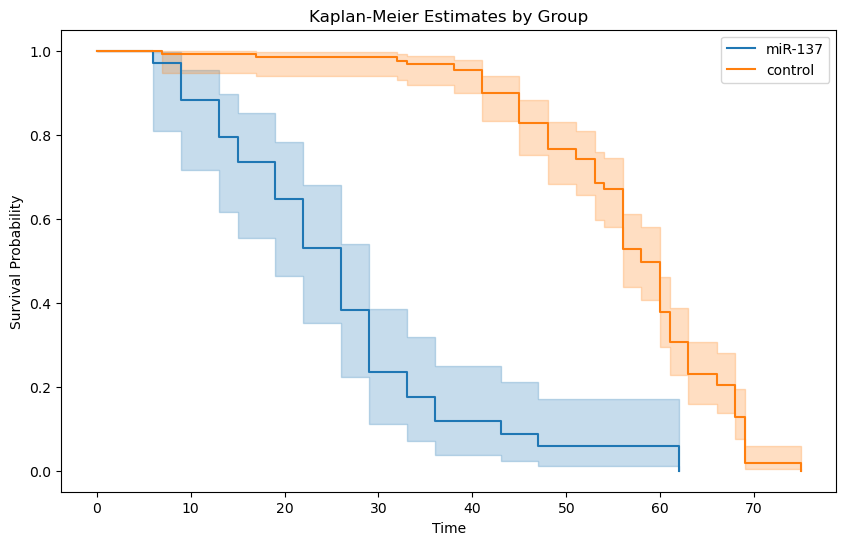

In [42]:
groups = data['group'].unique()

# Initialize the plot
plt.figure(figsize=(10, 6))

for group in groups:
    group_data = data[data['group'] == group]
    kmf.fit(durations=group_data['T'], event_observed=group_data['E'], label=group)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Estimates by Group')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

In [44]:
from lifelines.statistics import logrank_test

group1 = data[data['group'] == 'control']
group2 = data[data['group'] == 'miR-137']

results = logrank_test(group1['T'], group2['T'], event_observed_A=group1['E'], event_observed_B=group2['E'])
print(results)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         122.25 <0.005     91.99


In [46]:
from lifelines import CoxPHFitter

# Preparing the data for the Cox model
data['group'] = data['group'].astype('category').cat.codes  # Convert group to numerical codes

cph = CoxPHFitter()
cph.fit(data, duration_col='T', event_col='E')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 163 total observations, 7 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 163
number of events observed = 156
   partial log-likelihood = -613.18
         time fit was run = 2024-11-10 13:42:36 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
group      2.05      7.79      0.22            1.63            2.48                5.09               11.91

           cmp to    z      p  -log2(p)
covariate                              
group        0.00 9.46 <0.005     68.14
---
Concordance = 0.66
Partial AIC = 1228.36
log-likelihood ratio test = 66.25 on 1 df
-log2(p) of ll-ratio test = 51.16


## Summary and Interpretation

In this notebook, we conducted a comprehensive survival analysis using synthetic data. We explored the dataset, visualized survival distributions, estimated Kaplan-Meier survival curves, and applied the Cox proportional hazards model.

### Key Takeaways
1. **Kaplan-Meier Curves**: Show survival probabilities over time for different groups.
2. **Cox Model**: Provides hazard ratios for covariates, showing their relative impact on survival.

These techniques provide valuable insights into survival data, applicable to fields such as healthcare, engineering, and business.
